# Fitting EZmock with redshift-space clustering

-----

This Jupyter notebook provides a step-by-step guide to generating EZmock catalogues using custom input parameters. It also shows how to compare the resulting redshift-space clustering measurements with references.

## 1. Importing modules

To use the `EZmock` Python package, you must first compile the `libEZmock` C library.
In the root directory of the EZmock repository, run the following commands:
```bash
make
make install
```

You can modify `options.mk` to change compilation settings if needed. After compilation, a `build` directory will be created, containing the following library files:
- `build/include/EZmock.h`
- `build/lib/libEZmock.so`

Next, navigate to the `python` directory and install the `EZmock` Python package using:
```bash
pip install .
```

In [1]:
import os
import numpy as np
from pathlib import Path
from EZmock import EZmock
from pyclustering import pyclustering

## 2. EZmock setup

In this section, we define the runtime parameters that are intended to remain fixed during the EZmock calibration process. These include cosmological parameters, mock configurations, output paths, and the number of threads for parallelisation.

We also provide a helper function to simplify the workflow. This function uses the `EZmock` package to generate mock catalogues, and then measures and plots clustering statistics using the `pyclustering` package. Note that most of the clustering settings are specified in the configuration files located in the `conf` directory.

In [2]:
# EZmock parameters
Omega_m0 = 0.315192
redshift = 2
Lbox = 2000
Ngrid = 280
ntracer = 3288003

# Input linear power spectrum ########### ![TBD]

# klin=np.loadtxt('conf/Planck15.UNIT.loguniform.pk')[:, 0]
# plin=np.loadtxt('conf/Planck15.UNIT.loguniform.pk')[:, 1]

# Factor to be multiplied to the z-velocities for redshift-space distortion
rsd_fac = (1 + redshift) / (100 * np.sqrt(Omega_m0 * (1 + redshift)**3 + (1 - Omega_m0)))

# Output directory
odir = 'output'

# Number of threads
nthread = 16

In [3]:
def run_and_plot_EZmock(ez, pyc, params):
    """
    Run EZmock with the given parameters and plot the clustering statistics.
    
    Parameters:
    ez (EZmock): The EZmock instance.
    pyc (pyclustering): The pyclustering instance.
    params (dict): List of EZmock parameters to be run.
    """
    fnames = []
    for param in params:
        rho_c, rho_exp, pdf_base, sigma_v = param
        fname = f'{odir}/EZmock_L{Lbox:g}_N{Ngrid:d}_c{rho_c:g}_e{rho_exp:g}_b{pdf_base:g}_v{sigma_v:g}.dat'

        if not os.path.exists(fname):
            print(f'Running EZmock with parameters: {param}')
            # Run EZmock
            ez.populate_tracer_to_file(rho_c, rho_exp, pdf_base, sigma_v, ntracer, fname, rsd_fac=rsd_fac)

        fnames.append(fname)
            
        # Measure clustering statistics
        pyc.run(fname, Lbox)

    # Plot clustering statistics
    pyc.plot(fnames)

## 3. Initialising Python class instances

In this section, we initialise the `EZmock` and `pyclustering` class instances.

### EZmock

We compute the structure growth parameters within the $\Lambda$CDM framework using the cosmological parameters defined in the previous section. For non-standard cosmologies, these parameters can be set manually using the `set_growth_params` routine.

To enhance the BAO strength in EZmock, one can adjust the `BAO_enhance` parameter in the `setup_linear_pk` routine. It is recommended to tune this parameter *after* calibrating the other parameters, and to use fixed-amplitude initial conditions to reduce the impact of cosmic variance on the fitting process.

Since the BAO strength is fixed in this tutorial, the Zel'dovich dark matter density field does not alter during the calibration and can be generated in advance. In this example, we generate the density field from a random initial condition with fixed amplitudes. If you wish to use a predefined white noise or displacement field instead, please refer to the `create_dens_field_from_wn` and `create_dens_field_from_disp` functions in the `EZmock` package.

**Note**: Generally the `fixamp` option should be *disabled* for the mass production of mock catalogues for covariance estimation, as fixing the amplitude suppresses statistical fluctuations (see [Angulo & Pontzen (2016)](https://arxiv.org/abs/1603.05253)).


### pyclustering

Here, we create the `pyclustering` instance by specifying:
- The output directory for clustering measurements
- The extenal codes used for measuring clustering statistics
- The reference clustering measurements for calibration

The clustering measurement codes include:
- `POWSPEC`: https://github.com/cheng-zhao/powspec
- `FCFC`: http://github.com/cheng-zhao/FCFC
- `bispec`: Available upon request

In [4]:
ez = EZmock(Lbox=Lbox, Ngrid=Ngrid, seed=42, nthread=nthread)
# ez.eval_growth_params(z_out=redshift, z_pk=0, Omega_m=Omega_m0)
# ez.setup_linear_pk(klin, plin)


mydx=np.loadtxt('/data/users/zsy/2LPTdisp/2lpt_fnl200_L2000_G280_z2p0_dispx_7890.txt')
mydy=np.loadtxt('/data/users/zsy/2LPTdisp/2lpt_fnl200_L2000_G280_z2p0_dispy_7890.txt')
mydz=np.loadtxt('/data/users/zsy/2LPTdisp/2lpt_fnl200_L2000_G280_z2p0_dispz_7890.txt')
ez.create_dens_field_from_disp(mydx,mydy,mydz, deepcopy=True)

In [5]:
clustering_dir = str((Path().resolve() / 'clustering').resolve())
pk_ref = f'{clustering_dir}/pk_ref.txt'
xi_ref = f'{clustering_dir}/xi02_ref.txt'
bk_ref=f'{clustering_dir}/BK_UNIT_DESI_Shadab_HOD_snap97_ELG_v1_4col.dat'
pyc = pyclustering(workdir=str(Path().resolve()),
    pk_exe='/opt/bin/POWSPEC',
    xi_exe='/opt/bin/FCFC_2PT_BOX',
    bk_exe='/opt/bin/bispec_box',
    pk_ref=pk_ref,
    xi_ref=xi_ref,
    bk_ref=bk_ref,
    nthread=nthread, verbose=False)

## 4. Set EZmock calibration parameters

The free parameters for the effective bias model in EZmock can be set using lists in the following order:
```python
[rho_c, rho_exp, pdf_base, sigma_v]
```

A brief description of each parameter is provided in the table below.

| Parameter  | Symbol           | Description                                |
|------------|------------------|--------------------------------------------|
| `rho_c`    | $\rho_{\rm c}$   | Critical density for structure formation   |
| `rho_exp`  | $\rho_{\rm exp}$ | Scaling parameter for density modification |
| `pdf_base` | $b$              | Base value for power-law PDF mapping       |
| `sigma_v`  | $\nu$            | Dispersion of peculiar velocity            |

For more detailed explanations of these parameters, see [Zhao et al. (2021)](https://arxiv.org/abs/2007.08997). The impacts of these parameters on clustering statistics can be found in the [\[parameter cheatsheet\]](doc/EZmock_params_cheatsheet.pdf).

You can define multiple sets of parameter values at once via a list of lists. They will be used to generate mocks and compute clustering statistics in sequence if necessary.

**Tips**:
- It is recommended to limit the number of parameter sets (typically fewer than 6), as too many curves may overcrowd the resulting clustering plots.
- For parameters that are no longer of interest, consider commenting them out instead of deteting them. This helps maintain a clear record of the calibration history.

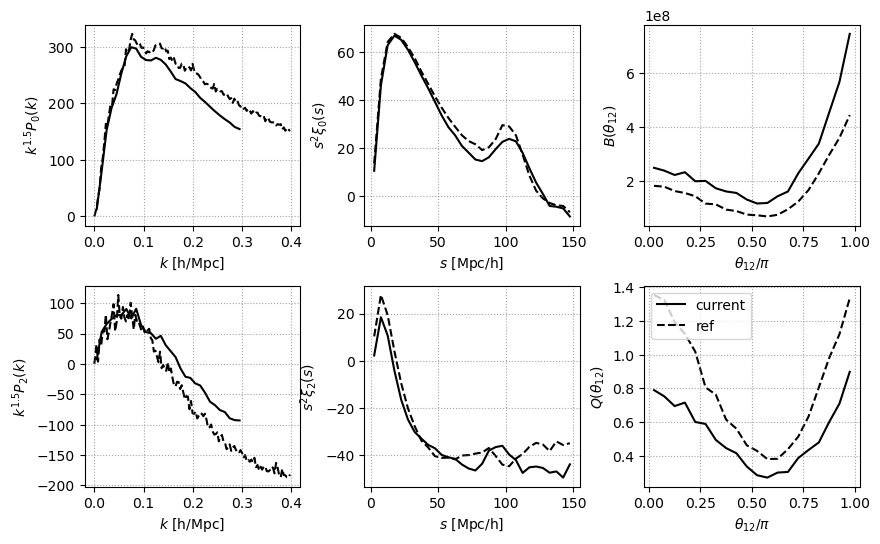

In [6]:
params = [
  # [0.8, 1, 0.3, 200],
  # [0.8, 1, 0.4, 200],
  # [0.8, 2, 0.3, 200],
  # [0.8, 4, 0.3, 200],
  # [0.8, 4, 0.4, 200],
  # [1., 4, 0.3, 0],
  # [1., 1, 0.3, 0],
  # [1., 1.5, 0.25, 0],
  # [1.02, 1.7, 0.25, 0],
  # [1.02, 1.7, 0.25, 200],
  # [1.02, 1.7, 0.27, 300],
  # [1.02, 1.7, 0.3, 300],
  # [1.02, 1.7, 0.3, 500],
  # [1.1, 1.45, 0.055, 355]
  # [1.02, 1.7, 0.35, 500],
  # [1.05, 1.7, 0.3, 500],
  # [1.03, 1.7, 0.3, 550],
  # [1.03, 1.7, 0.3, 500],
  # [1.02, 2, 0.3, 500],
  [1.025, 1, 0.3, 410],
  # [1.02, 2, 0.3, 410],
  # [1.02, 2, 0.3, 420],
  # [1.02, 1.7, 0.33, 420],
]

run_and_plot_EZmock(ez, pyc, params)


## 5. Run EZmock and make clustering plots

EZmock catalogues and their corresponding clustering statistics will be generated and plotted sequentially for each parameter set defined in the previous section. Rerunning this routine will *not* repeat the calculations unless the data files are manually deleted.

In the resulting plots:
- The last parameter set is treated as the *current* model and is highlighted using *black solid* curves.
- The reference clustering measurements are shown as *black dashed* curves for comparison.

Note that to have access to the coordinates and peculiar velocities of EZmock catalogues directly in Python, please use the `populate_tracer` routine from the `EZmock` package, rather than `populate_tracer_to_file` used by the helper function `run_and_plot_EZmock`.